In [1]:
# Install packages directly into the selected kernel environment
%pip install pandas numpy matplotlib statsmodels scikit-learn pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Step 2A: Setup and Data Acquisition (FRED) - FIX ---
import pandas as pd
from pandas_datareader import data as pdr
import datetime

# Define the sample period (A slightly earlier end date can help avoid partial quarters)
start = datetime.datetime(2008,1,1)
end   = datetime.datetime(2024,3,31) # Changed end date to a clean quarter-end

# 1. Macroeconomic Variables (Independent Variables, X)
gdp_q = pdr.DataReader('GDPC1','fred',start,end)       # Quarterly
unemp_m = pdr.DataReader('UNRATE','fred',start,end)    # Monthly
rate_m = pdr.DataReader('FEDFUNDS','fred',start,end)   # Monthly

# 2. Net Interest Income (Dependent Variable, Y)
nii_q = pdr.DataReader('QBPQYNTIY','fred',start,end)

# --- Data Alignment and Cleaning ---

# Convert monthly series to quarterly by taking the mean of the quarter's months
# Use 'QE' (Quarter End) as suggested in the warning.
unemp_q = unemp_m.resample('QE').mean()
rate_q = rate_m.resample('QE').mean()

# Merge all series. We will use inner join to keep only common dates, then dropna()
# We will use .ffill() on the UNRATE and FEDFUNDS to ensure we have the most recent data point for the quarter end.
# This approach ensures alignment on the quarter-end dates (like 2024-03-31).

# Start with the naturally quarterly series (GDP and NII)
df = pd.concat([gdp_q, nii_q], axis=1)

# Add the resampled monthly data. Reindex to match the quarterly data and use forward fill
# to handle any minor misalignment or missing quarters in the monthly to quarterly step.
df = pd.concat([df, unemp_q.reindex(df.index, method='ffill'), rate_q.reindex(df.index, method='ffill')], axis=1)

# Final cleanup and renaming
df.columns = ['gdp','nii','unemp','rate']
df = df.dropna()
df.index.name = 'date'


print("--- Raw FRED Data (Levels) ---")
print(df.head())
print(f"\nData Sample Size: {len(df)} quarters")

--- Raw FRED Data (Levels) ---
                  gdp        nii     unemp      rate
date                                                
2008-04-01  16943.291  96562.369  5.000000  3.176667
2008-07-01  16854.295  95127.464  5.333333  2.086667
2008-10-01  16485.350  96991.751  6.000000  1.940000
2009-01-01  16298.262  99867.129  6.866667  0.506667
2009-04-01  16269.145  99398.033  8.266667  0.183333

Data Sample Size: 64 quarters


In [3]:
# --- Step 2B: Prepare the Data (First Differences) ---

# make quarter-to-quarter changes
df_diff = df.diff().dropna()  # first differences -> Δ variables

# rename for clarity
df_diff = df_diff.rename(columns={'nii':'dNII','gdp':'dGDP','unemp':'dUnemp','rate':'dRate'})

print("\n--- Differenced FRED Data (Changes) ---")
print(df_diff.head())

# Quick peek at correlations
print("\n--- Correlations of Changes (Preliminary Check) ---")
print(df_diff[['dNII','dGDP','dUnemp','dRate']].corr())


--- Differenced FRED Data (Changes) ---
               dGDP      dNII    dUnemp     dRate
date                                             
2008-07-01  -88.996 -1434.905  0.333333 -1.090000
2008-10-01 -368.945  1864.287  0.666667 -0.146667
2009-01-01 -187.088  2875.378  0.866667 -1.433333
2009-04-01  -29.117  -469.096  1.400000 -0.323333
2009-07-01   57.136   244.403  1.033333 -0.003333

--- Correlations of Changes (Preliminary Check) ---
            dNII      dGDP    dUnemp     dRate
dNII    1.000000  0.107683 -0.139962  0.250576
dGDP    0.107683  1.000000  0.388887  0.040381
dUnemp -0.139962  0.388887  1.000000 -0.382818
dRate   0.250576  0.040381 -0.382818  1.000000


In [4]:
# --- Step 3A: Build Champion Model: OLS Regression (Initial Fit) ---
import statsmodels.api as sm

# Define independent (X) and dependent (y) variables
X = df_diff[['dGDP','dUnemp','dRate']]
y = df_diff['dNII']
X = sm.add_constant(X)  # Adds the intercept (constant)

# Fit OLS model on the full dataset (for initial inspection)
ols_full = sm.OLS(y, X).fit()

print("--- OLS Model Summary (Full Data) ---")
print(ols_full.summary())

--- OLS Model Summary (Full Data) ---
                            OLS Regression Results                            
Dep. Variable:                   dNII   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.767
Date:                Sun, 28 Sep 2025   Prob (F-statistic):              0.163
Time:                        19:13:19   Log-Likelihood:                -604.72
No. Observations:                  63   AIC:                             1217.
Df Residuals:                      59   BIC:                             1226.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        9

In [5]:
# --- Step 3B: Build Challenger Model: Simple Moving Average (MA) ---

# Moving Average (MA) calculation: rolling mean of last 4 quarters for dNII
df_diff['MA4'] = df_diff['dNII'].rolling(window=4).mean()

# Create a one-step-ahead naive forecast (MA_pred)
df_forecast = df_diff.copy()
# shift(1) means the forecast for Q(t) is the rolling mean calculated *up to* Q(t-1)
df_forecast['MA_pred'] = df_forecast['MA4'].shift(1)

print("\n--- Moving Average Forecast Sample ---")
print(df_forecast[['dNII','MA4','MA_pred']].dropna().head())


--- Moving Average Forecast Sample ---
                dNII         MA4     MA_pred
date                                        
2009-07-01   244.403  1128.74300   708.91600
2009-10-01   959.158   902.46075  1128.74300
2010-01-01  8833.248  2391.92825   902.46075
2010-04-01 -1687.179  2087.40750  2391.92825
2010-07-01  -137.742  1991.87125  2087.40750


In [6]:
# --- Step 4: Backtesting (train/test split + metrics) ---
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Split index (70% train / 30% test)
# The data starts in 2008Q2. The split should be around 2019Q1/Q2.
split_point = int(len(df_diff) * 0.7)
train = df_diff.iloc[:split_point]
test = df_diff.iloc[split_point:]

print(f"Train Period: {train.index.min().strftime('%Y-%m-%d')} to {train.index.max().strftime('%Y-%m-%d')}")
print(f"Test Period: {test.index.min().strftime('%Y-%m-%d')} to {test.index.max().strftime('%Y-%m-%d')}")

# OLS: fit on train, predict on test
X_train = sm.add_constant(train[['dGDP','dUnemp','dRate']])
y_train = train['dNII']
X_test = sm.add_constant(test[['dGDP','dUnemp','dRate']])
y_test = test['dNII']

# Fit the Champion model only on the training data
ols_train = sm.OLS(y_train, X_train).fit()
# Predict on the unseen test data
ols_pred = ols_train.predict(X_test)

# MA predictions for test (aligning the index)
ma_pred = df_forecast['MA_pred'].loc[test.index].dropna()
# Ensure y_test also aligns for MA comparison (MA loses first 4 test points due to its construction)
y_test_ma = y_test.loc[ma_pred.index]


# Metrics function
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

# OLS Metrics
rmse_ols = rmse(y_test, ols_pred)
mape_ols = mean_absolute_percentage_error(y_test, ols_pred)

# MA Metrics
rmse_ma = rmse(y_test_ma, ma_pred)
mape_ma = mean_absolute_percentage_error(y_test_ma, ma_pred)

print("\n--- Backtesting Results (Out-of-Sample) ---")
print(f"OLS (Champion) RMSE: {rmse_ols:.4f} | MA (Challenger) RMSE: {rmse_ma:.4f}")
print(f"OLS (Champion) MAPE: {mape_ols:.4f} | MA (Challenger) MAPE: {mape_ma:.4f}")

champion_model = "OLS" if rmse_ols < rmse_ma else "Moving Average"
print(f"\nChampion Selection: The **{champion_model}** model is the better performer (lower RMSE/MAPE).")

Train Period: 2008-07-01 to 2019-04-01
Test Period: 2019-07-01 to 2024-01-01

--- Backtesting Results (Out-of-Sample) ---
OLS (Champion) RMSE: 7067.0198 | MA (Challenger) RMSE: 6343.1297
OLS (Champion) MAPE: 1.8925 | MA (Challenger) MAPE: 2.1341

Champion Selection: The **Moving Average** model is the better performer (lower RMSE/MAPE).


In [9]:
# --- Step 5A: Stress Test Simulation (FINAL FIX) ---
import numpy as np

# Get OLS coefficients from the trained model (from Step 11)
params = ols_train.params
print("OLS Model Coefficients (Trained on FRED Data):")
print(params)

# Define a severe stress change vector (Quarterly Changes)
# dGDP: -500.0 (Billion USD)
# dUnemp: 3.0 (Percentage Points)
# dRate: 1.0 (Percentage Points)
stress = {'dGDP': -500.0, 'dUnemp': 3.0, 'dRate': 1.0}

# FIX: Create a single row of data for prediction, including the 'const' term explicitly,
# and ensuring the column names and order match params.index.

# 1. Start with the constant value of 1.0
prediction_row = {'const': 1.0}

# 2. Add the stress shock values
prediction_row.update(stress)

# 3. Create the prediction DataFrame using the parameters index for correct column order
# This guarantees the structure needed by ols_train.predict()
stress_df = pd.DataFrame([prediction_row])[params.index]

# Make the prediction
pred_dNII_stress = ols_train.predict(stress_df)[0]

print(f"\nPredicted ΔNII under stress = {pred_dNII_stress:.2f} (Millions of USD change)")

# Calculate context for the drop relative to the average quarterly NII level
# The 'test' data frame was defined in Step 11.
avg_nii_level_test = df['nii'].loc[test.index].mean()
percent_impact = (pred_dNII_stress / avg_nii_level_test) * 100

print(f"Average NII Level (Test Period): {avg_nii_level_test:.2f} Million USD")
print(f"Stress Impact: Predicted ΔNII results in a {percent_impact:.2f}% change relative to the average NII level.")

OLS Model Coefficients (Trained on FRED Data):
const      841.753423
dGDP         2.034155
dUnemp    1202.307893
dRate      870.876321
dtype: float64

Predicted ΔNII under stress = 4302.48 (Millions of USD change)
Average NII Level (Test Period): 149700.82 Million USD
Stress Impact: Predicted ΔNII results in a 2.87% change relative to the average NII level.


In [10]:
# --- Step 6: Diagnostics (quick checks for model risk note) ---
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# We need the training data and trained model from Step 11
# X_train and ols_train were defined there.

# residuals
resid = ols_train.resid

# Durbin-Watson (autocorrelation)
dw = durbin_watson(resid)
print(f"Durbin-Watson Statistic: {dw:.4f}")

# Breusch-Pagan test (heteroskedasticity)
# (X_train must include the constant, which it does)
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, X_train)
print(f"Breusch-Pagan p-value (Heteroskedasticity): {f_pvalue:.4f}")

# Final print summary for the note
print("\n--- Model Risk Notes Summary ---")
dw_status = "PROBLEM (Positive Autocorrelation)" if dw < 1.5 else "OK (No strong autocorrelation)"
bp_status = "YES (Suggest HAC Robust SE)" if f_pvalue < 0.05 else "NO"
print(f"Durbin-Watson ({dw:.2f}): {dw_status}")
print(f"Heteroskedasticity (p={f_pvalue:.4f}): {bp_status}")

Durbin-Watson Statistic: 2.0192
Breusch-Pagan p-value (Heteroskedasticity): 0.5623

--- Model Risk Notes Summary ---
Durbin-Watson (2.02): OK (No strong autocorrelation)
Heteroskedasticity (p=0.5623): NO


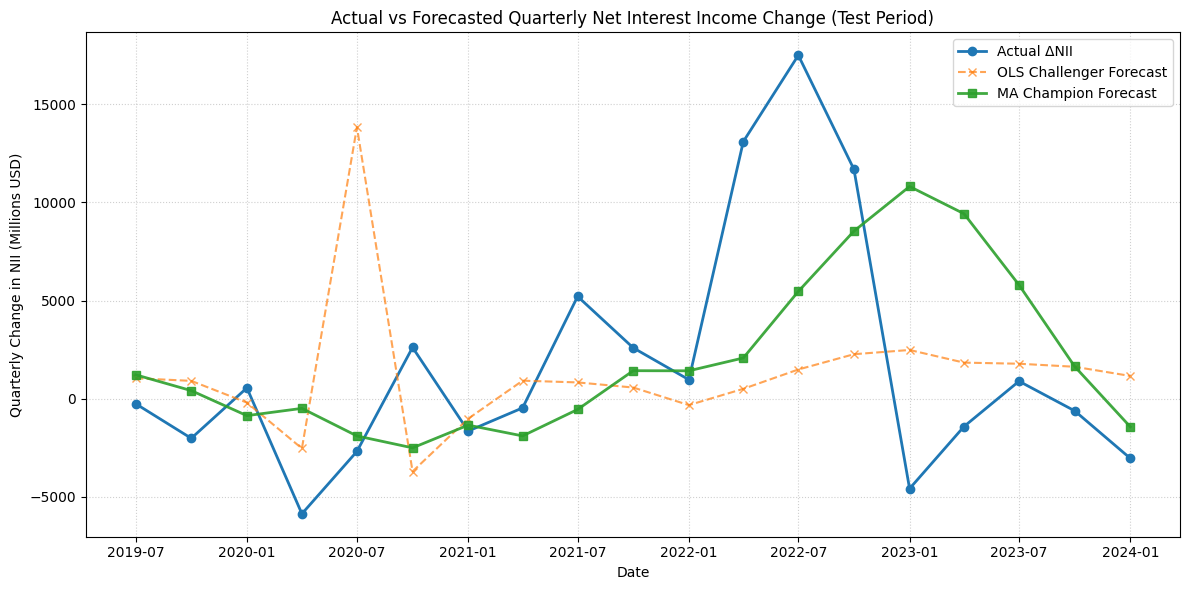

In [11]:
# --- Step 7: Final Plots ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual ΔNII', marker='o', linewidth=2)
plt.plot(y_test.index, ols_pred, label='OLS Challenger Forecast', marker='x', linestyle='--', alpha=0.7)
plt.plot(ma_pred.index, ma_pred, label='MA Champion Forecast', alpha=0.9, marker='s', linewidth=2)
plt.legend()
plt.title('Actual vs Forecasted Quarterly Net Interest Income Change (Test Period)')
plt.ylabel('Quarterly Change in NII (Millions USD)')
plt.xlabel('Date')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('actual_vs_forecast.png', dpi=150)
plt.show()